# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

sns.set()

df = pd.read_csv('data/human_body_temperature.csv')

In [48]:
# functions
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

Explore the dataset.

In [49]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.6+ KB


There are three columns in this dataframe: temperature (a numerical datatype), gender (a string datatype) and heart rate (a numerical datatype). There are a total of 130 rows or observations. It seems there are no null objects so cleaning may not be necessary. 

In [51]:
df.describe()

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


### Q1. Is the distribution of body temperatures normal?

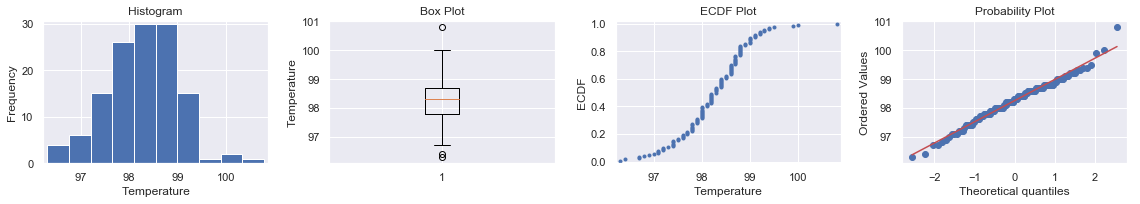

In [52]:
temperature = df.temperature
x_temp, y_temp = ecdf(temperature)

_ = plt.figure(figsize=(16,3))

_ = plt.subplot(1,4,1)
_ = plt.hist(temperature)
_ = plt.xlabel('Temperature')
_ = plt.ylabel('Frequency')
_ = plt.title('Histogram')
_ = plt.margins(.02)

_ = plt.subplot(1,4,2)
_ = plt.boxplot(temperature)
_ = plt.ylabel('Temperature')
_ = plt.title('Box Plot')

_ = plt.subplot(1,4,3)
_ = plt.plot(x_temp, y_temp, marker='.', linestyle='none')
_ = plt.xlabel('Temperature')
_ = plt.ylabel('ECDF')
_ = plt.title('ECDF Plot')
_ = plt.margins(.02)

_ = plt.subplot(1,4,4)
_ = stats.probplot(temperature, plot=plt)

plt.tight_layout()
plt.show()

Based on the graphs above, the temperatures look **fairly normal** with an ever so slight skew to the left. The probability plot shows that the data lines up pretty well with an ideal normal distribution (the red line). 

### Q2. Is the sample size large? Are the observations independent?

The sample dataset is **reasonably large** because the sample size, n is greater than or equal to 30. Also, we can probably safely assume that the observations are **independent** since the sample size is not be greater than 10% of the world population.

### Q3. Is the true population mean really 98.6 degrees F?

First, *define the null hypothesis*:

H0 = The mean temperature is 98.6 degrees F

HA = The mean temperature is not 98.6 degrees F

Consider an *alpha parameter*:

alpha = 0.05


In [117]:
# Bootstrap hypothesis testing.

empirical_diff = abs(np.mean(temperature) - 98.6)

# shift the temperature since we want to see if the means are equal

temperature_shifted = temperature - np.mean(temperature) + 98.6

bs_reps = draw_bs_reps(temperature_shifted, np.mean, 10000)

temp_diff = abs(bs_reps - 98.6)

p = np.sum(temp_diff >= empirical_diff)/len(temp_diff)
p

0.0

As seen above the null hypothesis, **H0 is rejected** since p-value is less than alpha.

Frequentist statistical testing. We would use a **1 sample test** because we aren't comparing two sample populations just one sample from a given test statistic. In this situation, it would be appropriate to use a **z-statistic** since the sample is large enough that we can estimate that its standard deviation (standard error) is equal to the population's standard deviation.

In [68]:
# Z-statistic testing

mean = np.mean(temperature)

std_error = np.std(temperature)/np.sqrt(len(temperature))

# the z-score for 95% confidence is 1.96
confidence_int = [round(mean - 1.96*std_error,3), round(mean + 1.96*std_error,3)]

print('The mean of the sample is ', round(mean,2), ' +/- ', round(std_error,2), 'with a 95% confidence interval of', confidence_int,'.')

The mean of the sample is  98.25  +/-  0.06 with a 95% confidence interval of [98.124, 98.375] .


As seen with the bootstrap testing, because 98.6 is not within the confidence interval, we would **reject the null hypothesis, H0** using z-statistic testing.

In [69]:
len(temperature)

130

In [73]:
# t-statistic testing

# Use the same stats as the z-score but change the z-score for the t-score
# Using a t table, the t-score is not given for a d.f. of 129 (sample size - 1)

# However, we can estimate it using a d.f. of 100 which would equal 1.984.

t_confidence_int = [round(mean - 1.984*std_error,3), round(mean + 1.984*std_error,3)]

print('The mean of the sample is ', round(mean,2), ' +/- ', round(std_error,2), 'with a 95% confidence interval of', t_confidence_int,'.')

The mean of the sample is  98.25  +/-  0.06 with a 95% confidence interval of [98.122, 98.376] .


The result of the t-testing is only slightly different from the z-testing since the sample size is large and appoximately normal.

### Q4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

First, we should see if the conditions are met for this test. We will be **randomly** selecting the samples. The sample population is approximately **normal**, as seen above, therefore it pasts the condition of normality. Lastly, even without replacement, we would have an **independent** sample because 10 is less than 10% of the size of the sample of the population that we're sampling from. 

Since the sample size of 10 is small and it wouldn't be safe to assume that the standard deviation of this sample is the standard deviation of the population, **it would be more appropriate to use the t-statistic**.

[98.6 98.6 98.8 97.7 97.6 98.6 96.3 97.1 97.4 97.4]


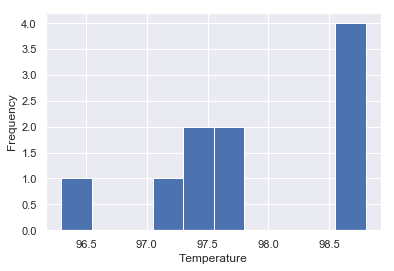

In [81]:
# get a sample of 10

sample_10 = np.random.choice(temperature,10)

print(sample_10)

_ = plt.hist(sample_10)
_ = plt.xlabel('Temperature')
_ = plt.ylabel('Frequency')
plt.show()

In [82]:
# z-statistic testing

mean = np.mean(sample_10)

std_error = np.std(sample_10)/np.sqrt(len(sample_10))

# the z-score for 95% confidence is 1.96
confidence_int = [round(mean - 1.96*std_error,3), round(mean + 1.96*std_error,3)]

print('The mean of the sample is ', round(mean,2), ' +/- ', round(std_error,2), 'with a 95% confidence interval of', confidence_int,'.')

The mean of the sample is  97.81  +/-  0.25 with a 95% confidence interval of [97.329, 98.291] .


In [83]:
# t-statistic testing

# Use the same stats as the z-score but change the z-score for the t-score
# The t-statistic for a d.f. of 9 which would equal 2.262.

t_confidence_int = [round(mean - 2.262*std_error,3), round(mean + 2.262*std_error,3)]

print('The mean of the sample is ', round(mean,2), ' +/- ', round(std_error,2), 'with a 95% confidence interval of', t_confidence_int,'.')

The mean of the sample is  97.81  +/-  0.25 with a 95% confidence interval of [97.255, 98.365] .


From the testing above, we can see that the t-statistic's confidence interval is wider than the z-statistic's. This is probably due to the uncertainty of the sample. 

### Q5. At what temperature should we consider someone's temperature to be "abnormal"?
<li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.

This question is interesting as it doesn't clearly define what is abnormal. For all intents and purposes of the project, I will define something that is 'abnormal' is a temperature far from the mean. Therefore, the alpha of this test would be 0.00001 (or 0.001%). I feel this is a satisfactory definition of 'abnormal'. Therefore, any temperature outside the following confidence intervals should be considered 'abnormal'.

In [89]:
# bootstrap approach

bs_reps = draw_bs_reps(temperature, np.mean, 10000)

confidence_interval = np.percentile(bs_reps, [0.0005, 99.9995])

print('A 99.999% confidence interval of the bootstrap testing is', confidence_interval, '.')

A 99.999% confidence interval of the bootstrap testing is [97.99123065 98.54503865] .


In [90]:
# frequentist approach

# Z-statistic testing

mean = np.mean(temperature)

std_error = np.std(temperature)/np.sqrt(len(temperature))

# the z-score for 99.999% confidence is 3.89
confidence_int = [round(mean - 3.89*std_error,3), round(mean + 3.89*std_error,3)]

print('The mean of the sample is ', round(mean,2), ' +/- ', round(std_error,2), 'with a 95% confidence interval of', confidence_int,'.')

The mean of the sample is  98.25  +/-  0.06 with a 95% confidence interval of [98.0, 98.498] .


According to the testing above, 'abnormal' temperature would include a temperature of 98.6 F.

### Q6. Is there a significant difference between males and females in normal temperature?

First, we should set up the hypothesis test:

<li>H0: there is no difference in normal temperatures between males and females | mean(males) - mean(females) = 0 </li>
<li>H1: there is a difference in normal temperatures between males and females | mean(males) - mean(females) != 0 </li>

alpha = 0.01 (or 1%)

In [109]:
# I will use the bootstrap method. I am utilizing this method because I want to practice hacker stats.

# create the two sample populations

temp_w = df.temperature[df.gender == 'F']
temp_m = df.temperature[df.gender == 'M']

empirical_diff = np.mean(temp_w) - np.mean(temp_m)

# shift the mean since we are testing that the means are equal 

temp_w_shifted = temp_w - np.mean(temp_w) + np.mean(temperature)
temp_m_shifted = temp_m - np.mean(temp_m) + np.mean(temperature)

# create bootstrap reps for each of the populations

bs_reps_w = draw_bs_reps(temp_w_shifted, np.mean, 10000)
bs_reps_m = draw_bs_reps(temp_m_shifted, np.mean, 10000)

difference_in_genders = bs_reps_w - bs_reps_m

# find the p-value

p = np.sum(difference_in_genders >= empirical_diff)/len(difference_in_genders)
p

0.0105

According to the test above and the alpha that was chosen, we cannot **reject** the null hypothesis that the normal temperatures of men and women are the same. However, the p-value is really close to the alpha, meaning that a repeat of this test might have a different outcome depending on the randomness of the test above.